# Exploratory data analysis of rainfall data

In this notebook, I apply exploratory data analysis (EDA) methods to examine rainfall data collected in Auckland between 1872 and 1997, and I summarize the main findings.

The dataset consists of several tables sourced from the following website: <a href="https://environmentauckland.org.nz/Data/DataSet/Summary/Location/A64871M/DataSet/Rainfall/Continuous/Interval/Latest">Link to Website</a>. These five tables report the daily amount of rainfall (in millimetres) measured at two different locations. The data spans varying time intervals, ranging from 6 to 140 years, and includes both observed and synthesized values.

In this analysis, we focus on a single dataset: A64871M, which covers the period from 1872 to 1997. The data is stored in the file AucklandRainfall1872-1997.csv, comprising five columns and 31,652 rows. For our purposes, only two columns are required: the date and the amount of rainfall (in millimetres). The dates are provided in the NZST time zone (UTC +12). Measurement intervals vary, occurring every 1 to 10 days.

### 1. Importing Python libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
import calendar
from dateutil import tz

import matplotlib.pyplot as plt
import statsmodels as sm

#setting plot size
plt.rcParams['figure.figsize'] = [14,8]

### 2. Reading input file

In [2]:
%%time
file = '../Data/AucklandRainfall1872-1997.csv'

rain=pd.read_csv(file, skiprows=3, header=None,
                  names=['Date','rain_value', 'grade', 'interpol_type', 'event_timestamp'],
                  parse_dates=['Date'],
                  index_col='Date')
rain.head(5)

CPU times: total: 15.6 ms
Wall time: 42.6 ms


,rain_value,grade,interpol_type,event_timestamp
Date,,,,
1872-01-03,0.00,200,5,NaN
1872-01-04,3.81,200,5,NaN
1872-01-05,2.03,200,5,NaN
1872-01-09,0.00,200,5,NaN
1872-01-10,0.51,200,5,NaN


### 3. Removing unnecessary columns

Three columns: grade, interpol_type, and event_timestamp have the same values throughout the table. At this stage of the analysis, we can remove them from the table. 

In [3]:
#count unique values
display(rain['grade'].value_counts(sort = True, normalize = True))
display(rain['interpol_type'].value_counts(sort=True, normalize = True))
display(rain['event_timestamp'].value_counts(sort=True, normalize = True))
    
rain = rain.drop(columns = ['event_timestamp', 'grade', 'interpol_type'])

grade
200    1.0
Name: proportion, dtype: float64

interpol_type
5    1.0
Name: proportion, dtype: float64

Series([], Name: proportion, dtype: float64)

### 4. Displaying remaining columns

In [4]:
rain.info()
rain.tail(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31652 entries, 1872-01-03 00:00:00 to 1997-09-30 08:30:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rain_value  31652 non-null  float64
dtypes: float64(1)
memory usage: 494.6 KB


,rain_value
Date,
1997-09-24 08:30:00,63.4
1997-09-25 08:30:00,15.0
1997-09-26 08:30:00,0.4
1997-09-29 08:30:00,80.2
1997-09-30 08:30:00,19.3


### 5. Exploring Date column

The Date column was initially not set to include a time zone. To address this, we will assign a time zone to the DateTimeIndex based on UTC, using the IANA time zone database via the dateutil library. This database is regularly updated and accounts for daylight saving time and other regional changes, which is particularly important when working with datasets spanning long time periods.

By examining the Date column, we find that only one measurement was recorded per day, and that on approximately 30% of days, no rainfall amount was documented.

In [5]:
%%time
#timezone information
rain.index.tzinfo

#setting the local timezone
rain_tz = rain.copy() 

#original date column
rain_tz['Date_naive'] = rain_tz.index

#timezone offset relative to UTC 
rain_tz = rain_tz.tz_localize(tz = tz.gettz('Pacific/Auckland'))
display(rain_tz.head(2))

print('Start date: ', min(rain_tz.index), 'End date: ', max(rain_tz.index))
print('Unique dates:', len(rain_tz.index.unique()), '.v.s. Total number of dates:', rain_tz.shape[0])

delta = max(rain_tz.index)-min(rain_tz.index)
no_measurements = delta.days-rain_tz.shape[0]
print('Total number of days:', delta.days, '.vs. Number of days without measurements:',no_measurements, '---', round(no_measurements/delta.days*100, 0), ' %')

,rain_value,Date_naive
Date,,
1872-01-03 00:00:00+11:39:04,0.00,1872-01-03
1872-01-04 00:00:00+11:39:04,3.81,1872-01-04


Start date:  1872-01-03 00:00:00+11:39:04 End date:  1997-09-30 08:30:00+12:00
Unique dates: 31652 .v.s. Total number of dates: 31652
Total number of days: 45926 .vs. Number of days without measurements: 14274 --- 31.0  %
CPU times: total: 266 ms
Wall time: 261 ms


### 6. Exploring the rain_value column

By exploring the rain_value column, we can identify the number of days with zero rainfall, as well as the dates with the maximum recorded rainfall.

In [6]:
%%time
#frequency of rain values
rain_days = rain_tz['rain_value'].value_counts(dropna = True, sort = True)

print('Number of days without rain:', rain_days[0], '---', round(rain_days[0]/rain_tz.shape[0] *100, 0),'%')

#dates with the maximum rainfalls:
rain_sorted = rain_tz.sort_values(by = 'rain_value', ascending=False)
display(rain_sorted.head(5))

Number of days without rain: 8473 --- 27.0 %


,rain_value,Date_naive
Date,,
1936-02-02 00:00:00+12:00,162.05,1936-02-02
1985-05-23 00:00:00+12:00,156.60,1985-05-23
1979-02-18 00:00:00+13:00,142.20,1979-02-18
1917-02-04 00:00:00+11:30,140.72,1917-02-04
1989-08-26 00:00:00+12:00,133.30,1989-08-26


CPU times: total: 15.6 ms
Wall time: 8.68 ms


In [7]:
#distribution of numbers
rain.describe()

,rain_value
count,31652.000000
mean,4.723530
std,9.145826
min,0.000000
25%,0.000000
50%,1.270000
75%,5.330000
max,162.050000


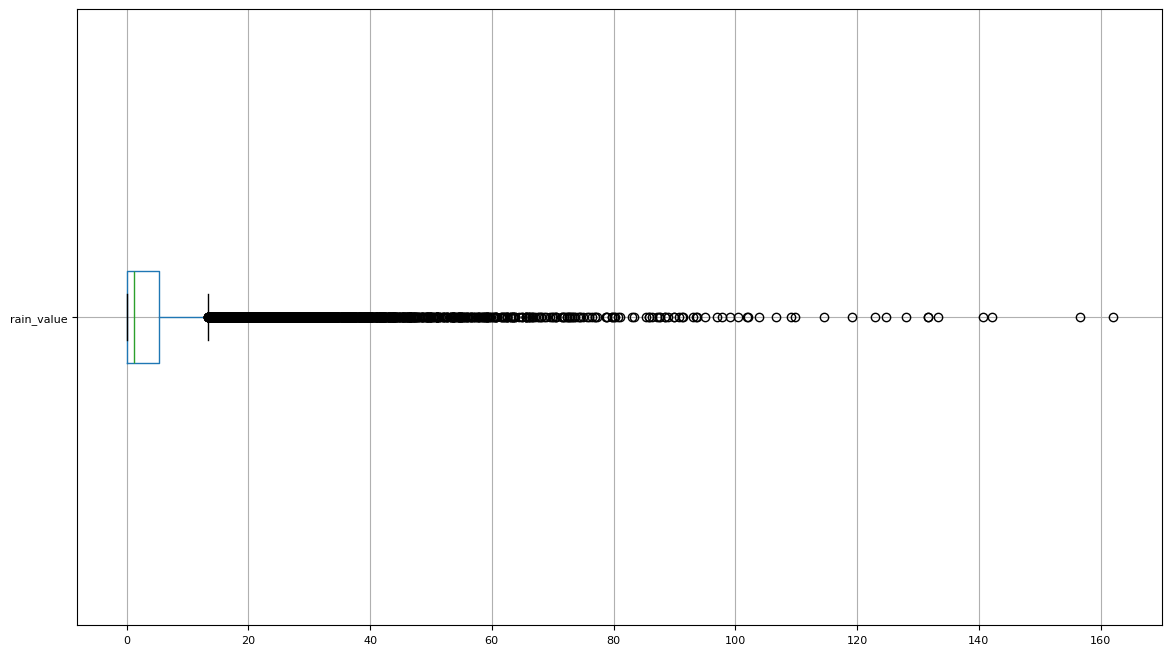

In [8]:
rain.boxplot(fontsize=8, vert=False)
plt.show()

### 7. Finding number of days with little rain


After excluding days with zero recorded rainfall, we can determine how many days had less than 20 mm of rainfall.

In [9]:
#amount of rain per day in mm
rain_c = 20

rain_sorted = rain_days.sort_index()

#values of rain between 0.1 and rain_c
days_no = rain_sorted[rain_sorted.index[1]:rain_c].values.sum()

#percentage of days with rain_c 
rain_perc = round(days_no/rain_tz.shape[0]*100, 0)

print('Number of days with rain less than', rain_c, ' mm/day:', days_no, '---', rain_perc, '%', '\n')

Number of days with rain less than 20  mm/day: 21512 --- 68.0 % 



### 8. Plotting three different time intervals

We will plot three selected two-year intervals—one from the beginning of the dataset, one from the middle, and one from the end. Assuming that all rainfall values were collected consistently and that zero values represent days without rain, we can expect to observe both seasonal patterns within each year and variations between different years.

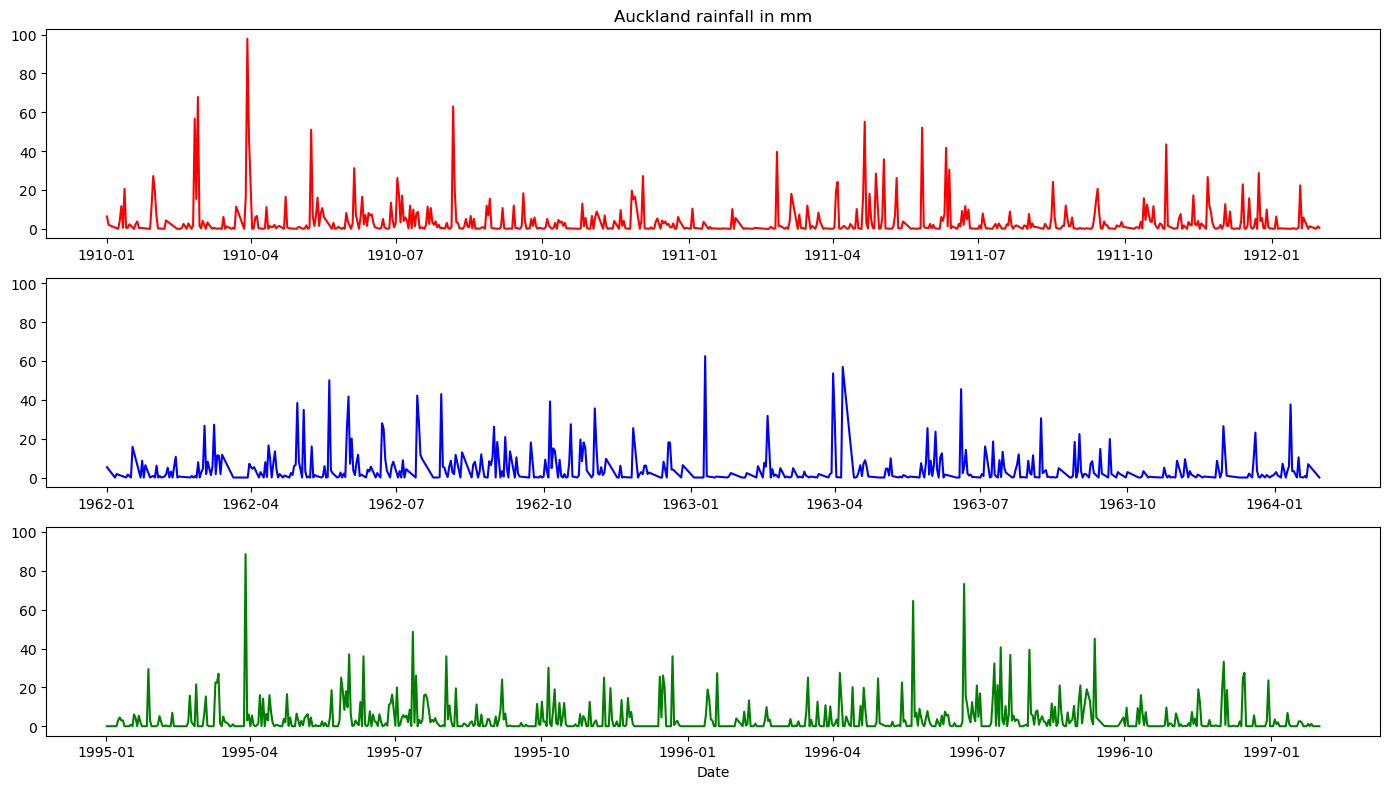

CPU times: total: 672 ms
Wall time: 664 ms


In [10]:
%%time
rain_1012 = rain['1910-01': '1912-01']
rain_6264 = rain['1962-01': '1964-01']
rain_9597 = rain['1995-01': '1997-01']

fig,ax = plt.subplots(3,1, sharey=True)
ax[0].plot(rain_1012.index, rain_1012['rain_value'], color = 'red')
ax[1].plot(rain_6264.index, rain_6264['rain_value'], color = 'blue')
ax[2].plot(rain_9597.index, rain_9597['rain_value'], color = 'green')

ax[2].set_xlabel('Date')
ax[0].set_title('Auckland rainfall in mm')

plt.tight_layout() 
plt.show()        

### 9. Plotting missing dates

We can explore whether the dates with missing measurements are evenly distributed throughout the dataset or concentrated in specific periods. For example, we will examine a noticeable dip in the mean resampled rainfall plot around the year 1914.

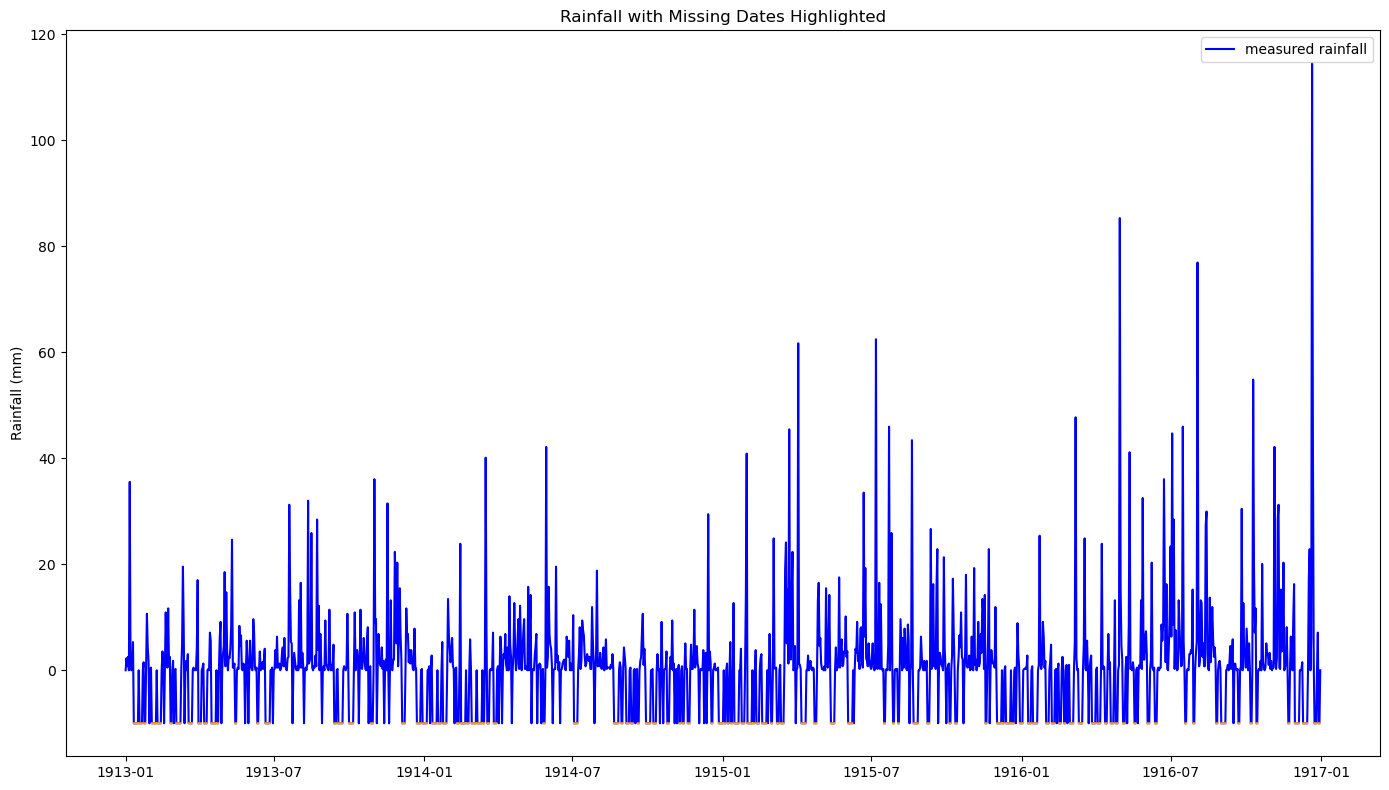

In [11]:
# Resample and fill gaps
rn = pd.date_range(start = rain.index.min(), end = rain.index.max())
rain1 = rain.reindex(rn)
rain1.index.name = 'date'

# Add rain_value with missing values as -10
rain1['rain_value'] = rain1['rain_value'].fillna(-10)

# Create a column to mark missing values only
rain1['missing'] = rain1['rain_value'].where(rain1['rain_value'] == -10)

rain1 = rain1['1913':'1916']

fig,ax = plt.subplots()
ax.plot(rain1.index, rain1['rain_value'], color ='blue', label = 'Observed')
ax.plot(rain1.index, rain1['missing'], color ='orange', label = 'Missing (-10)')
ax.legend()
ax.set_ylabel('Rainfall (mm)')
ax.legend(['measured rainfall'])
ax.set_title('Rainfall with Missing Dates Highlighted')
plt.tight_layout()
plt.show()      

### 10. Resampling data

To identify patterns and trends in the data, we can resample the rainfall data to obtain mean monthly and annual values. The annual plot shows low rainfall values around 1914 and 1915, indicating either a period of low rainfall or gaps in the rainfall records.

,rain_value
Date,
1872-01-31,0.917692
1872-02-29,6.810909
1872-03-31,5.115714
1872-04-30,5.624815
1872-05-31,3.402800


,rain_value
Date,
1872-12-31,4.456820
1873-12-31,4.429283
1874-12-31,3.863617
1875-12-31,4.938923
1876-12-31,4.053715


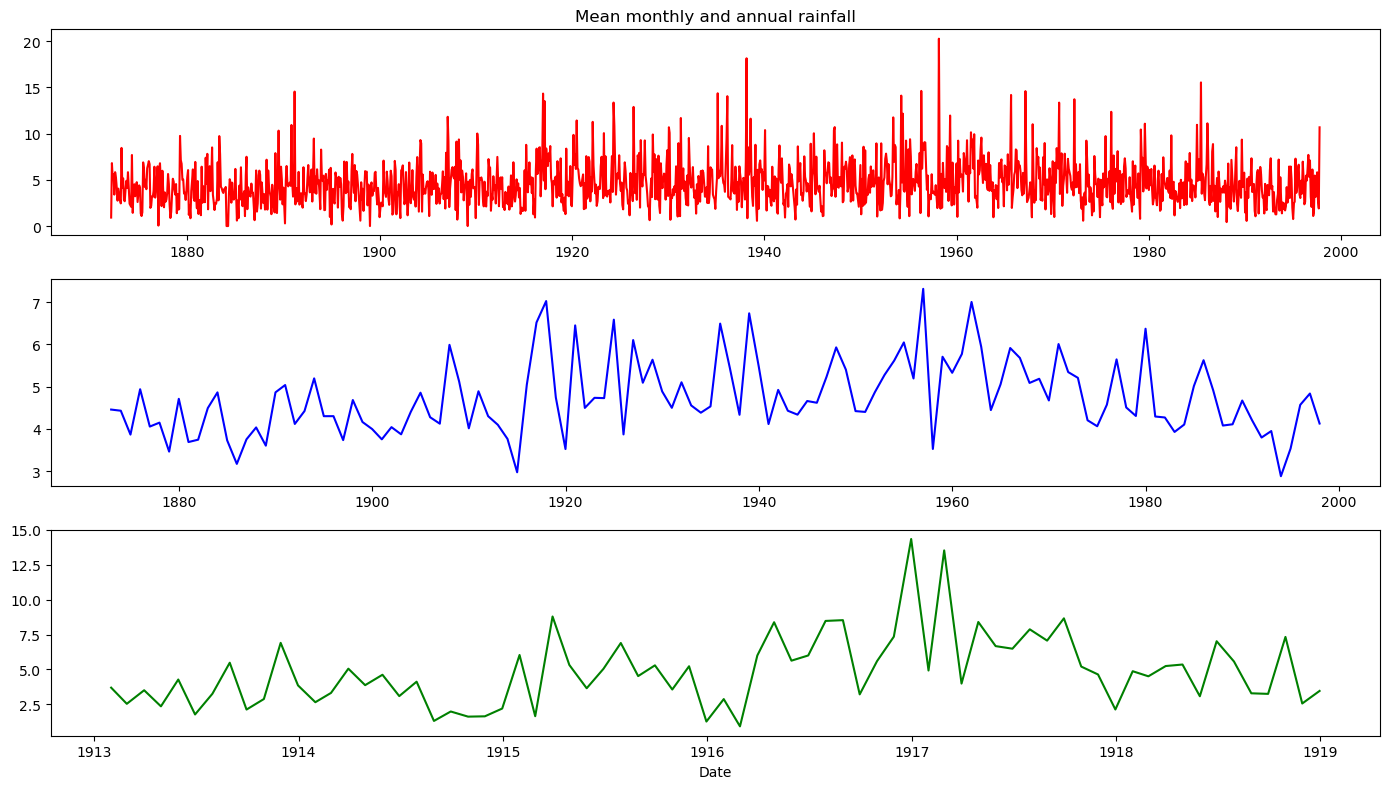

CPU times: total: 578 ms
Wall time: 586 ms


In [12]:
%%time
#Resampling the data to the average monthly and annual values
rain_monthly = rain.resample("ME").mean()
rain_annual = rain.resample("YE").mean()

display(rain_monthly.head())
display(rain_annual.head())

df = rain_monthly['1913':'1918']

fig,ax = plt.subplots(3,1)
ax[0].plot(rain_monthly.index, rain_monthly['rain_value'], color='red')
ax[1].plot(rain_annual.index, rain_annual['rain_value'], color='blue')
ax[2].plot(df.index, df['rain_value'], color='green')

ax[2].set_xlabel('Date')
ax[0].set_title('Mean monthly and annual rainfall')

plt.tight_layout() 
plt.show()      

### 11. Finding percentage of change using pct.change()

The percentage change is calculated based on the mean annual data.

       rain_value
count  125.000000
mean     0.022794
std      0.226423
min     -0.518641
25%     -0.132017
50%     -0.006179
75%      0.133601
max      0.832426


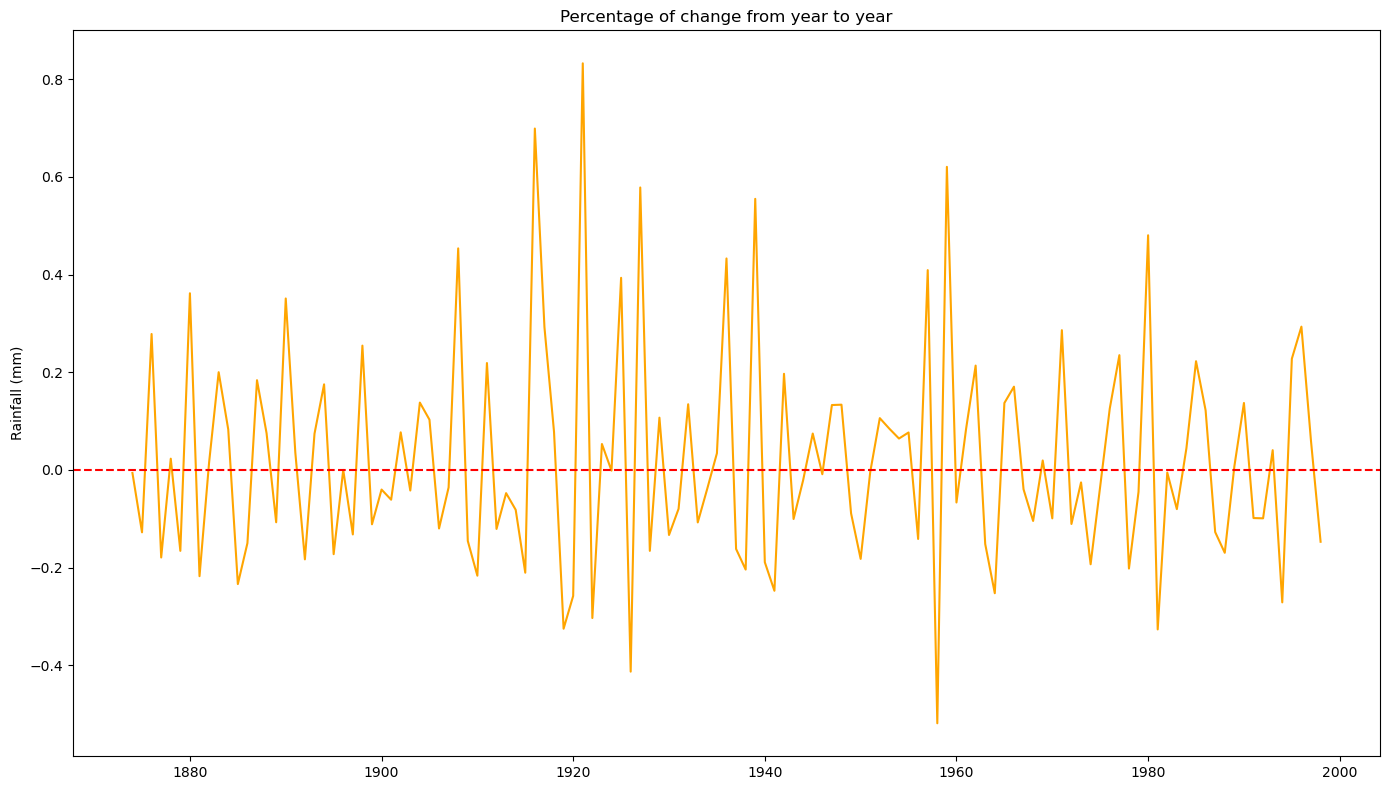

In [13]:
annual_change = rain_annual.pct_change()
print(annual_change.describe())

fig,ax = plt.subplots()
ax.plot(annual_change.index, annual_change['rain_value'], color ='orange')
ax.axhline(0,color='red', linestyle = '--')
ax.set_ylabel('Rainfall (mm)')
ax.set_title('Percentage of change from year to year')
plt.tight_layout() 
plt.show()   

### 12. Finding correlation using corr() function

There is no correlation between different segments of the rainfall time series data. This section presents an example of the correlation coefficient calculated using the percentage change and the corr() function.

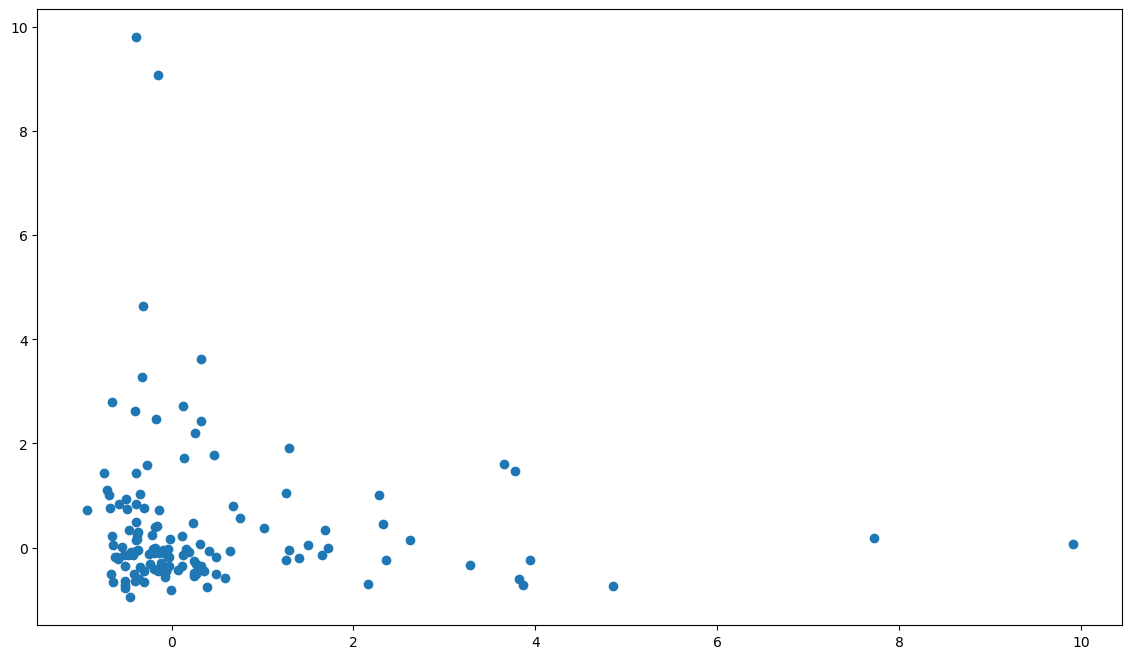

In [14]:
#percent of change
rain1c = rain_monthly['1923':'1933'].pct_change()
rain2c = rain_monthly['1934':'1944'].pct_change()

#correlation coefficient
correlation = rain1c['rain_value'].corr(rain2c['rain_value'])

plt.scatter(rain1c['rain_value'], rain2c['rain_value'])
plt.show()

#### Histogram of Monthly rain fall data

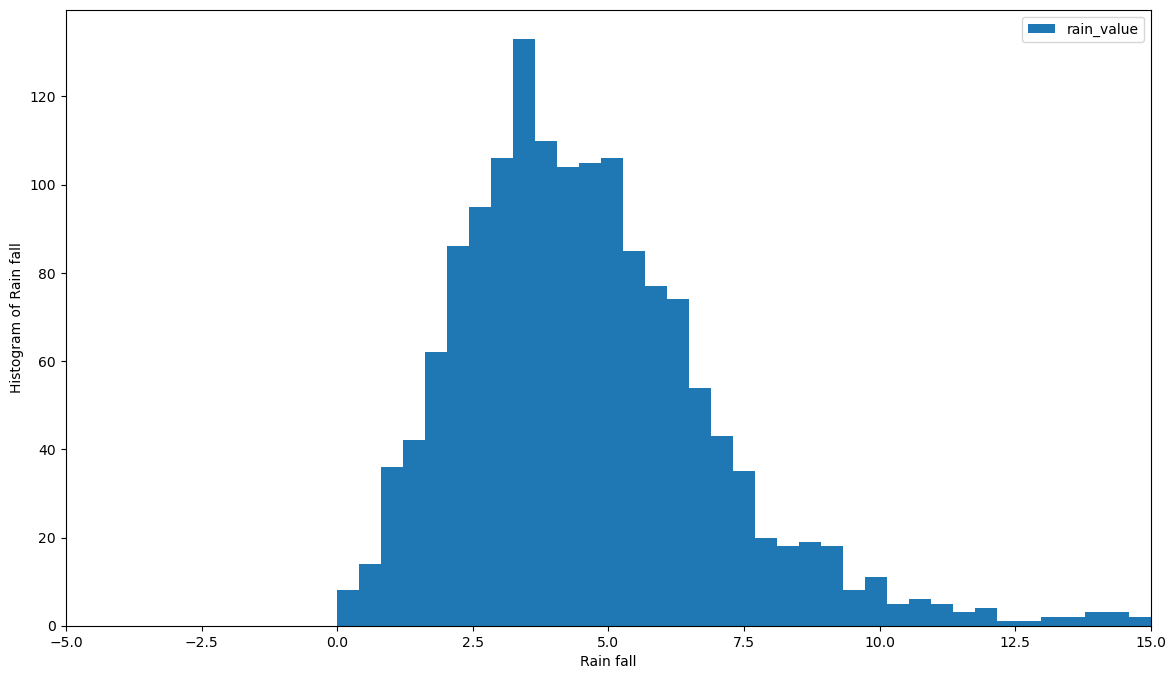

In [15]:
ax = rain_monthly.plot(kind='hist', bins=50)
ax.set_xlabel('Rain fall')
ax.set_ylabel('Histogram of Rain fall')
ax.set_xlim([-5,15])
plt.legend(fontsize=10)
plt.show()

### 13. Rolling windows

The above plots do not reveal clear patterns or trends. To better capture time series variations, we can apply a technique called the rolling window. By using a rolling window with the mean as the aggregate function, each calculated value will represent the average of the current and all previous data points within the window.

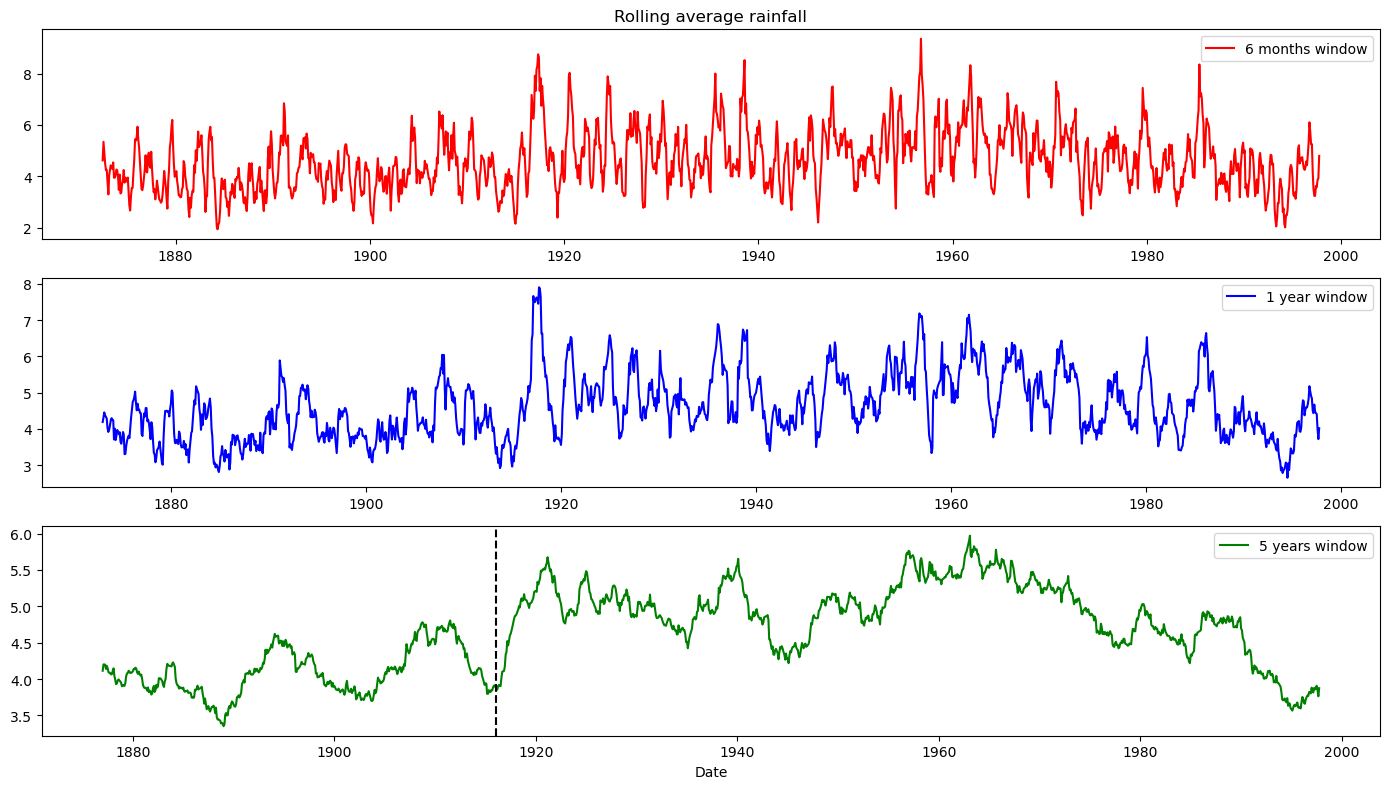

CPU times: total: 531 ms
Wall time: 545 ms


In [16]:
%%time
#6 months, 12 months and 5 years rolling average data
rain_monthly_rw = rain_monthly.rolling(6).mean()
rain_annual_rw = rain_monthly.rolling(12).mean()
rain_annual_rw2 = rain_monthly.rolling(60).mean()

fig,ax = plt.subplots(3,1)
ax[0].plot(rain_monthly_rw.index, rain_monthly_rw['rain_value'], color = 'red')
ax[1].plot(rain_annual_rw.index, rain_annual_rw['rain_value'], color = 'blue')
ax[2].plot(rain_annual_rw2.index, rain_annual_rw2['rain_value'], color = 'green')
#convert '1916' to datetime object
ax[2].axvline(pd.to_datetime('1916'), color='black', linestyle='--')  

ax[0].set_title('Rolling average rainfall')
ax[0].legend(['6 months window'])
ax[1].legend(['1 year window'])
ax[2].legend(['5 years window'])
ax[2].set_xlabel('Date')
plt.tight_layout() 
plt.show()

### 14. Zooming monthly rolling windows

By zooming in on three different periods, variations in the rainfall data become more apparent.

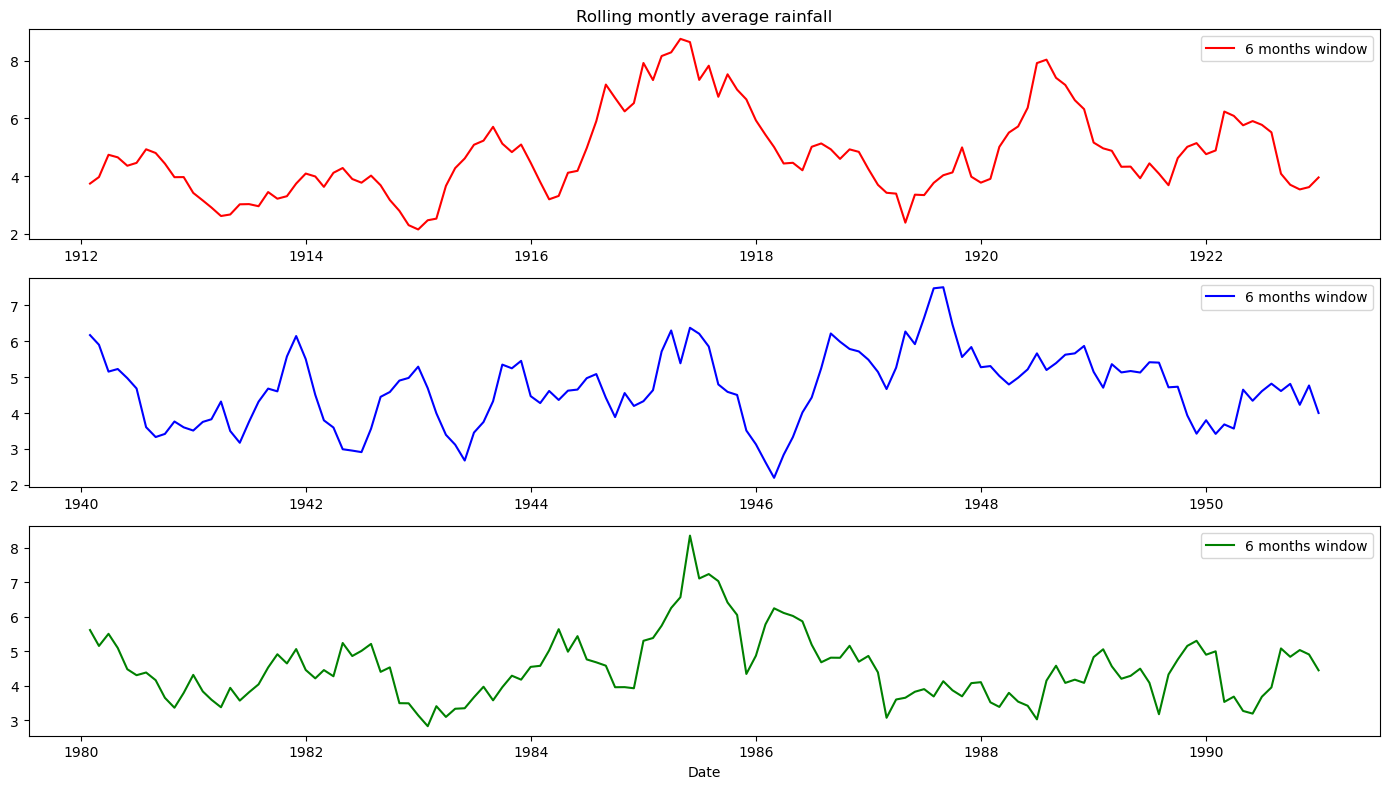

In [17]:
df1 = rain_monthly_rw['1912': '1922']
df2 = rain_monthly_rw['1940': '1950']
df3 = rain_monthly_rw['1980': '1990']

fig,ax = plt.subplots(3,1)
ax[0].plot(df1.index, df1['rain_value'], color = 'red')
ax[1].plot(df2.index, df2['rain_value'], color = 'blue')
ax[2].plot(df3.index, df3['rain_value'], color = 'green')

ax[0].set_title('Rolling montly average rainfall')
ax[0].legend(['6 months window'])
ax[1].legend(['6 months window'])
ax[2].legend(['6 months window'])
ax[2].set_xlabel('Date')
plt.tight_layout() 
plt.show()

### 15. Examining extreme changes in rainfall around the year 1914

We can zoom in and visually examine whether rainfall data are missing around the year 1914. The measurements indicate no change in the frequency of data collection, but there is a noticeable decrease in the recorded rainfall values.

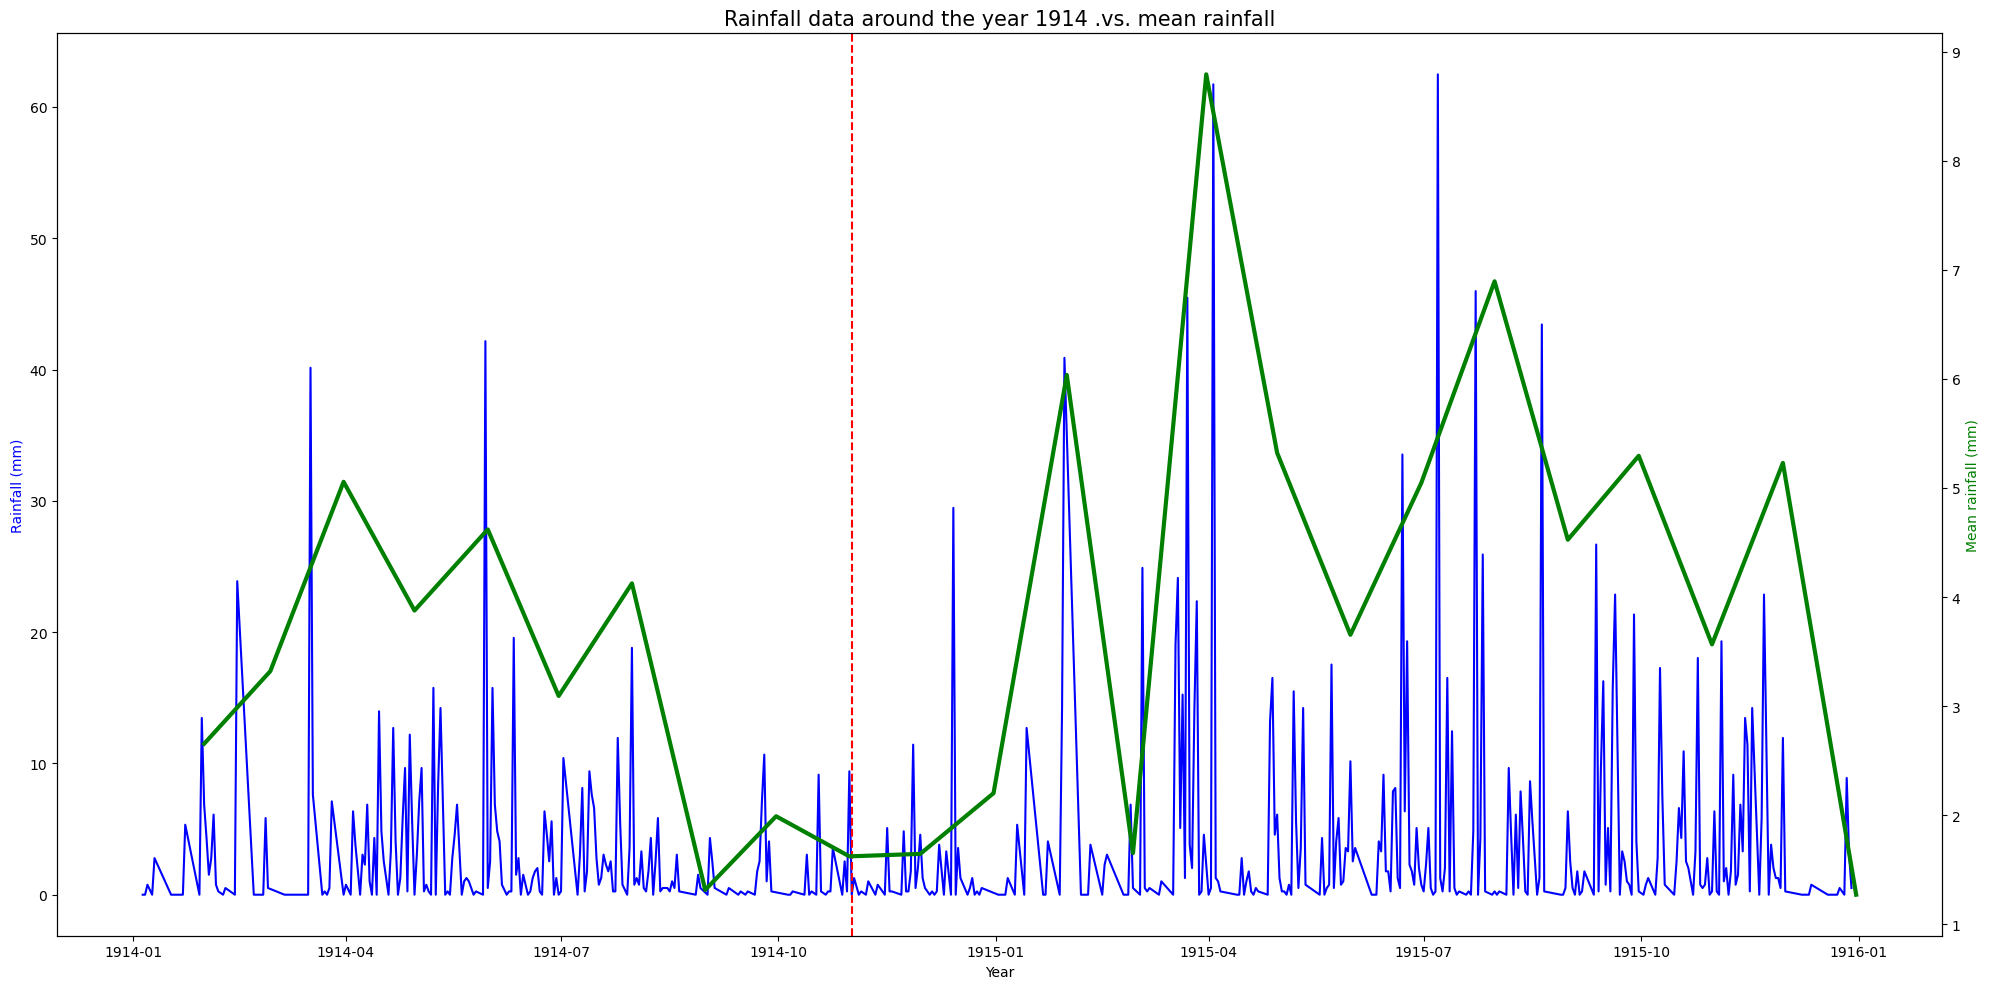

CPU times: total: 422 ms
Wall time: 449 ms


In [18]:
%%time
rain_1020 = rain['1914': '1915']

#mean rolling window
df = rain_monthly['1914': '1915']

fig,ax = plt.subplots(figsize = (20,10))
ax.plot(rain_1020.index, rain_1020['rain_value'], color = 'b')

ax.set_xlabel('Year')
ax.set_ylabel('Rainfall (mm)', color = 'b')
ax.set_title('Rainfall data around the year 1914 .vs. mean rainfall', fontsize=15)
#convert '1914-11' to datetime object
ax.axvline(pd.to_datetime('1914-11'), color='red', linestyle='--')  

ax2 = ax.twinx()
ax2.plot(df.index, df['rain_value'], color = 'g', linewidth=3)
ax2.set_ylabel('Mean rainfall (mm)',color = 'g')
plt.tight_layout() 
plt.show()

### 16. Plotting a bar graph of monthly rainfall

After grouping rainfall values by month and calculating the medians to reduce the impact of outliers, we can display a bar graph that approximates the distribution of monthly rainfall.

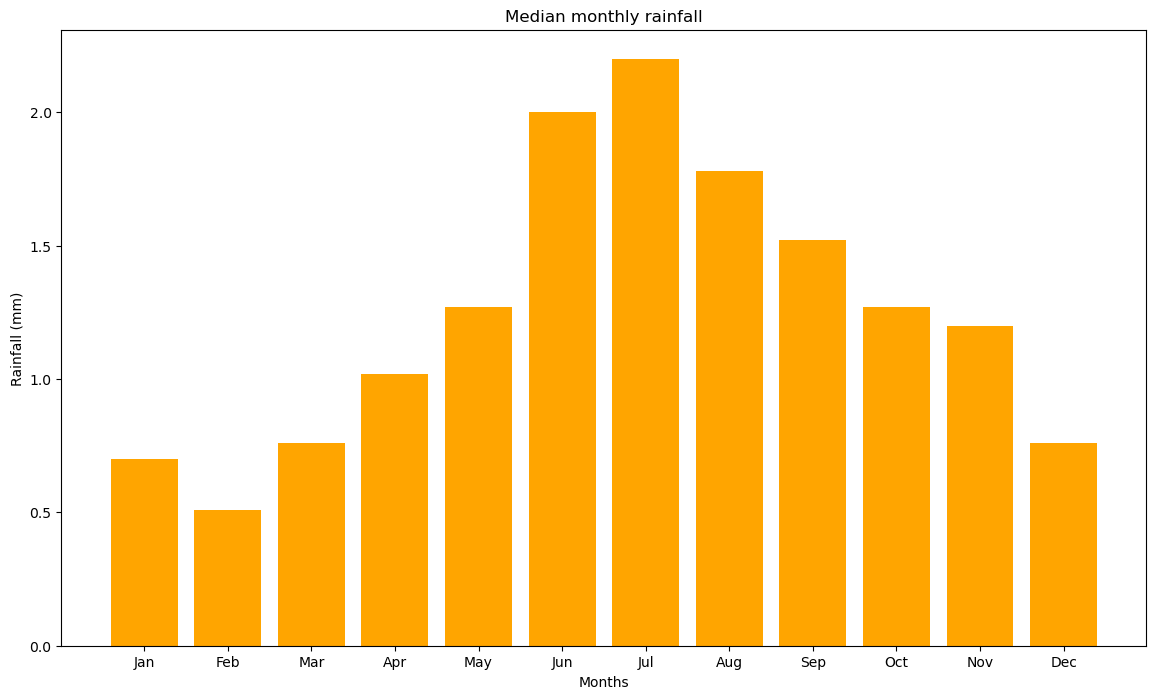

CPU times: total: 172 ms
Wall time: 174 ms


In [19]:
%%time
rain_new = rain.groupby(rain.index.month).median()

#column with months names
months = [calendar.month_abbr[i] for i in range(1,13)]
rain_new.index = months

fig,ax = plt.subplots( )
ax.bar(rain_new.index, rain_new['rain_value'], color = 'orange')
ax.set_xlabel('Months')
ax.set_ylabel('Rainfall (mm)')
ax.set_title('Median monthly rainfall')
#color = 'seagreen'

plt.show()